In [197]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")
sys.path.insert(0, "/home/tinkerer/Poisson_Solver/")

import numpy as np
import matplotlib.pyplot as plt
import dask.bag as db
from dask_quantumtinkerer import Cluster, cluster_options
import kwant
import itertools as it
from scipy.signal import find_peaks

import ccode.tools as tl
import ccode.finite_system as tj
import ccode.solvers as sl
import ccode.parameters as pm
import ccode.gates as gt
from ccode.plotting import plot_potential_lines

from Hamiltonian import discrete_system_coordinates, kwant_system, tight_binding_Hamiltonian
from potential import gate_potential, linear_problem_instance
from utility import prepare_voltages
from plotting import plot_potential
from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    SimpleVoltageLayer,
    TwoDEGLayer,
)

In [2]:
mu = pm.bands[0]
a = 10e-9

In [3]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/jtorresluna/trijunction_design/"

# Ring geometry

This notebook is an example of how to simulate different trijunction geometries and analyse the coupling of different MBS pairs.
We will cover:

* Make a trijunction geometry
* Extract the low energy spectra for each pair
* Analyse the peaks in the MBS coupling
* Make/calibrate a gate defined cavity
* Compute couplings in a gate-defined cavity

## Step 0: Define a geometry

In [4]:
# System parameters

R = 60
r = 51
a = 10e-9

geometry = {
    "l": 130*a,  # wire length
    "w": 7*a,  # wire width
    "a": a,  # lattice cte
    "side": 'up',  # central nanowire side
    "shape": 'ring',  # shape of cavity
    "R": R*a,  # length cavity
    "r": r*a,  # width cavity
}

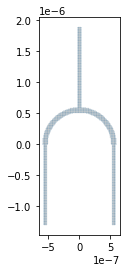

In [5]:
# Create kwant builder
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()
kwant.plot(trijunction);

In [6]:
# A solver that will be used to run calculations on the cluster for this geometry varying arbitrary parameters

n = 6  # number of eigenvalues
mu = pm.bands[0]  # lowest band
base_params = pm.junction_parameters(m_nw=[mu, mu, mu], m_qd=1e-3)

# Define solver
solver = sl.general_solver(geometries=[[trijunction, f_params]],
                           n=n,
                           base_parameters=base_params)


def wrap(arg):
    return solver(*arg)

## Step 1: Find optimal phases

The solver function takes a dictionary with the varying parameters, and computes the lowest `n` eigenvalues. The function for generating the parameters in this way, and for analysing the data that comes out of the calculation, are `pm.phase_params`, `pm.single_parameter`, `tl.coupling data`.

In [40]:
# Generate paramters for the calculation in dask_bag format
phis = np.linspace(0, 2, 100)
args = list(it.product([0], pm.phase_params()))
args_db = db.from_sequence(args)

In [41]:
# Run calculation
with Cluster(options) as cluster:
    cluster.adapt(minimum=1, maximum=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/0e822d015855416b9fea11ccc75703fb/status


In [42]:
spectra, couplings, wfs, peaks, widths = tl.coupling_data(result, n=n)

In [43]:
max_phis = phis[np.array(peaks).flatten()]

Text(81.0, 0.5, '$E[\\mu eV]$')

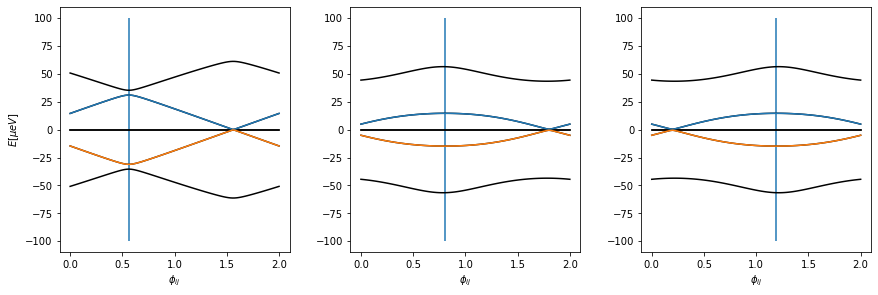

In [44]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
fig.tight_layout(w_pad=3)
phis = np.linspace(0, 2, 100)
for i in range(3):
    for level in spectra[i].T:
        ax[i].plot(phis, 1e6*level, c='black')
    ax[i].plot(phis, 1e6*couplings[i])
    ax[i].plot(phis, -1e6*couplings[i])
    ax[i].vlines(x=max_phis[i], ymin=-100, ymax=100)
    ax[i].set_xlabel(r'$\phi_{ij}$')
ax[0].set_ylabel(r'$E[\mu eV]$')

## Setp 2: Find MBS coupling

In [52]:
vals = np.linspace(0, 3e-3, 100)

In [216]:
# the function single parameter takes max_phis as an inpiut as well, i.e. the optimal phases for each pair
params = list(pm.single_parameter(key='mu_qd', vals=vals, max_phis=max_phis))
args = list(it.product([0], params))
args_db = db.from_sequence(args)

NameError: name 'max_phis' is not defined

In [47]:
# Run calculation
with Cluster(options) as cluster:
    cluster.adapt(minimum=1, maximum=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/45b42b5818cb494ea15b3b8f5d419860/status


In [48]:
kwargs = {'prominence': 10e-6}
spectra, couplings, wfs, peaks, widths = tl.coupling_data(result, n=n, **kwargs)

In [49]:
widths = np.array(widths)

Text(117.0, 0.5, '$E[eV]$')

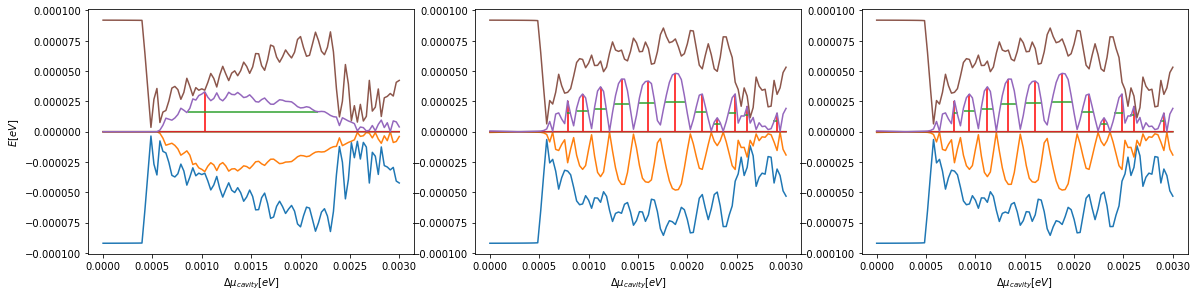

In [60]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
fig.tight_layout(w_pad=3)
phis = np.linspace(0, 2, 100)
for i in range(3):
    ax[i].plot(vals, spectra[i])
    ax[i].vlines(x=vals[peaks[i]], ymin=0, ymax=couplings[i][peaks[i]], color='red')
    heights, xmin, xmax = widths[i][1:]
    xmin = (vals[-1]-vals[0])*xmin/100 + vals[0] + (vals[1]-vals[0])/2
    xmax = (vals[-1]-vals[0])*xmax/100 + vals[0] + (vals[1]-vals[0])/2
    ax[i].hlines(y=heights, xmin=xmin, xmax=xmax, color="C2")
    ax[i].set_xlabel(r'$\Delta\mu_{cavity} [eV]$')
ax[0].set_ylabel(r'$E[eV]$')

# Step 3: Set up electrostatic gates

In [85]:
# Extra geometrical parameters
gap = 4
tunel_length = 5
wire_width = 13
y_shift = tunel_length + gap

In [86]:
# Boundaries within Poisson region
zmin = -0.5
zmax = 0.5
xmax = R + 2*gap + 2*wire_width
xmin = -xmax
ymin = 0
ymax = R + gap +tunel_length + y_shift
boundaries = [xmin, xmax, ymin, ymax, zmin, zmax]
total_width = 2*xmax
total_length = ymax

L = boundaries[3] - boundaries[2]
W = boundaries[1] - boundaries[0]

In [87]:
# Electrostatic parameters
thickness_barrier = 4
thickness_twoDEG = 4
thickness_gates = 6

permittivity_metal = 5000
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

grid_spacing_twoDEG = 1
grid_spacing_normal = 1
grid_spacing_dielectric = 5
grid_spacing_air = 5
grid_spacing_barrier = grid_spacing_normal
grid_spacing_gate = grid_spacing_twoDEG

In [88]:
gates_name, gates_vertex = gt.ring_gates(R, wire_width, gap, tunel_length)

In [89]:
# Solve for Poisson system
layout = Layout(total_width,
                total_length,
                grid_width_air=grid_spacing_air,
                margin=(50, 50, 50),
                shift=(0, total_length/2, 0))

layout.add_layer(
    TwoDEGLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG,
        add_to_previous_layer=False,
        fix_overlap=False,
        z_bottom=None
    ),
    center=True,
)

height = thickness_twoDEG / 2

layout.add_layer(
    SimpleChargeLayer(
        "Al2O3",
        thickness_barrier,
        permittivity_Al2O3,
        grid_spacing_barrier,
        add_to_previous_layer=False,
        fix_overlap=False,
        z_bottom=None
    )
)

height += thickness_barrier

layout.add_layer(OverlappingGateLayer(thickness_gates,
                                      permittivity_metal,
                                      grid_spacing_gate,
                                      layer_name=gates_name,
                                      gate_objects=gates_vertex,
                                      remove_points=False,
                                      add_to_previous_layer=False,
                                      z_bottom=height,
                                      fix_overlap=True
                                     )
            )

poisson_system = layout.build()

checking intersection
finished checking intersection
Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


In [90]:
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

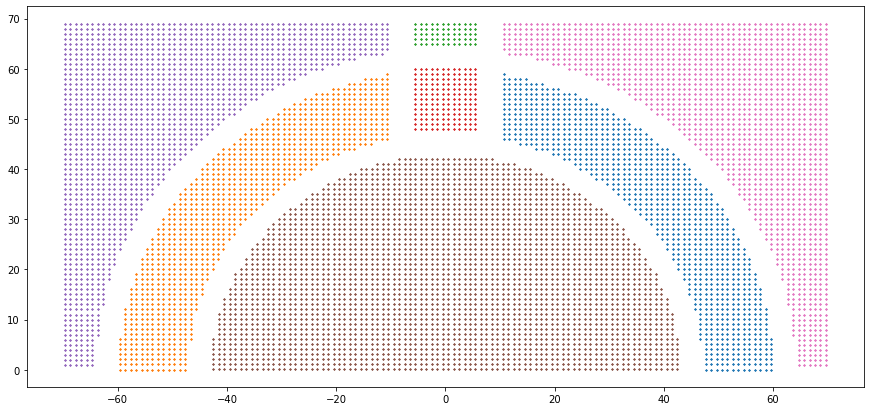

In [91]:
plt.figure(figsize = (15, 7))
for name, indices in voltage_regions.items():
    grid_to_plot = grid_points[indices][:, [0, 1]]
    plt.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)

In [92]:
linear_problem = linear_problem_instance(poisson_system)

In [213]:
def voltages(left_ring, right_ring, central, barrier, screen):
    voltages = {'left_ring': left_ring,
                'right_ring': right_ring,
                'central_ring_tunnel': central,
                'central_tunnel': barrier,
                'screening0': screen,
                'screening1': screen,
                'screening2': screen}
    return voltages

The function gate potential has been modified with respect to the original version in `spin-qubit`. The modified version takes two more parameters as input: `offset` and `grid_spacing`. These parameters are used to match the Poisson sites with a one-to-one correspondence to the sites in the kwant builder. The modified version is:

```python
def gate_potential(
    discrete_system, linear_problem, site_coords, site_indices, voltages, charges, offset, grid_spacing=1
):
    solution = _linear_solution(discrete_system, linear_problem, voltages, charges)

    potential = solution[site_indices]

    potential_dict = {}

    site_tuples = map(tuple, site_coords)

    for i, site_tuple in enumerate(site_tuples):
        if grid_spacing == 1:
            potential_dict[ta.array((site_tuple-offset))] = potential[i]
        else:
            potential_dict[ta.array((site_tuple-offset)*grid_spacing)] = potential[i]

    return potential_dict

```

In [94]:
def potential(voltage_setup, offset=offset, grid_spacing=1):
    charges = {}
    clean_potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltage_setup,
        charges,
        offset,
        grid_spacing
    )
    return clean_potential

In [95]:
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('mixed', 'twoDEG')], boundaries=boundaries
)

crds = site_coords[:, [0, 1]]
offset = crds[0]%grid_spacing_twoDEG

In [177]:
depleted = -20e-3
voltage_setup = voltages(0e-3, depleted, 0e-3, 0, depleted)
smooth_potential = potential(voltage_setup)
smooth_potential.update(
    (key, -1 * value) for key, value in smooth_potential.items()
)

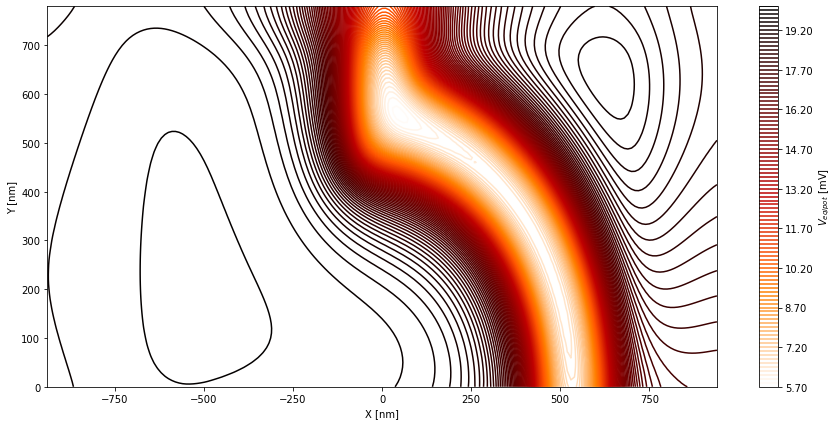

In [178]:
plot_potential_lines(potential=[smooth_potential], scale=10, figsize=(15, 7))

## Step 4: Map smooth potential to kwant lattice

This calculation needs to be moved to the cluster in order to be parallelized. The main problem of such approach is that the geometry is fixed in the calculation file, and does not allow changes as here in the notebook.
In this section we define a kwant builder that represents the 2DEG and that will be filled with the potential from Poisson calculations.

In [98]:
a = 10e-9
center = R - (R-r)/2
centers = [center*a, -center*a]
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'rectangle',
    "L": L*a,
    "W": W*a,
    "centers": centers
}

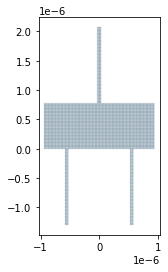

In [99]:
trijunction, f_params, f_params_potential = tj.finite_system(**geometry)
trijunction = trijunction.finalized()
kwant.plot(trijunction);

This solver is used to diagonalize the system filled with the smooth potential. This function takes a gate voltage configuration, calculates the potential, fills the kwant system, and then compute the eigenvalues and iegenvectors. Therefore, it requires `poisson_system` to be defined in the same environment.

In [210]:
# this function needs Poisson problem to be defined
import scipy.sparse.linalg as sla


def solver_electrostatics(tj_system, voltage_setup, n, params, eigenvecs=False):


    def eigensystem_sla(voltage_params, extra_params):

        params.update(extra_params)
        voltage_setup.update(voltage_params)

        system, f_params_potential = tj_system

        f_potential = tl.get_potential(potential(voltage_setup=voltage_setup, grid_spacing=10e-9))
        f_params = f_params_potential(potential=f_potential, params=params)
        ham_mat = system.hamiltonian_submatrix(sparse=True, params=f_params)

        if eigenvecs:
            evals, evecs = sl.sort_eigen(sla.eigsh(ham_mat.tocsc(), k=n, sigma=0))
        else:
            evals = np.sort(sla.eigsh(ham_mat.tocsc(), k=n, sigma=0, return_eigenvectors=eigenvecs))
            evecs = []

        return evals, evecs

    return eigensystem_sla

In [214]:
params = pm.junction_parameters(m_nw=np.array([mu, mu, mu]), m_qd=0)
voltage_setup = voltages(left_ring=1e-3,
                         right_ring=1e-3,
                         central=1e-3,
                         barrier=depleted,
                         screen=depleted)

In [215]:
n = 20
solver = solver_electrostatics(tj_system=[trijunction, f_params_potential],
                               voltage_setup=voltage_setup,
                               n=n,
                               params=params,
                               eigenvecs=False)


def wrapper(arg):
    return solver(*arg)

## Step 5: Find optimal phases

In [179]:
# in this case the solver will take two dictionaries, one for the Hamiltonian parameters, and another for the voltage setup
phases = pm.phase_params()[::3]
voltage_params = {'left_ring': 8e-3, 'right_ring': 8e-3, 'central_ring_tunnel': 8e-3}

In [184]:
args = list(it.product([voltage_params], phases))

In [185]:
%%time
# Calculation must be fully moved to the cluster in order to be parallelized
# Otherwise runs slowly
ens = []
vcs = []
for arg in args:
    evals, evecs = wrapper(arg)
    ens.append(evals)
    vcs.append(evecs)

CPU times: user 12min 47s, sys: 16.7 s, total: 13min 3s
Wall time: 13min 3s


In [186]:
ens = np.array(ens)

Text(0, 0.5, '$E$ [eV]')

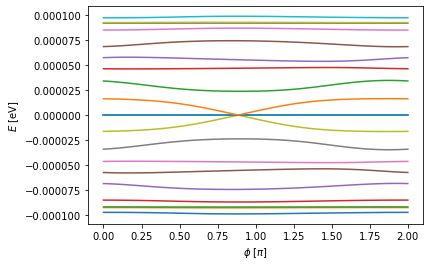

In [195]:
phis = np.linspace(0, 2, 100)
for level in ens.T:
    plt.plot(phis, level)
plt.xlabel(r'$\phi$ [$\pi$]')
plt.ylabel(r'$E$ [eV]')

In [200]:
coupling = ens.T[n//2+1]
where_max_phi = find_peaks(coupling)[0]
max_phi = np.pi*phis[where_max_phi]

## Step 6: Find MBS couplings

In [204]:
extra_params = {'phi1': max_phi[0], 'phi2': 0}
voltage_params = []
voltages = np.linspace(3, 10, 50)*1e-3
for voltage in voltages:
    voltage_params.append({'left_ring': voltage, 'right_ring': voltage, 'central_ring_tunnel': voltage})

In [206]:
args = list(it.product(voltage_params, [extra_params]))

In [207]:
%%time
# Calculation must be fully moved to the cluster in order to be parallelized
# Otherwise runs slowly
ens = []
vcs = []
for arg in args:
    evals, evecs = wrapper(arg)
    ens.append(evals)
    vcs.append(evecs)

CPU times: user 6min 30s, sys: 26.8 s, total: 6min 56s
Wall time: 6min 56s


In [208]:
ens = np.array(ens)

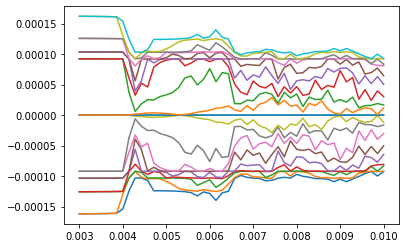

In [209]:
for level in ens.T:
    plt.plot(voltages, level)

The results do not look great immediately, but we still need to calibrate the gates.